# 廣告效益提升方案：A/B測試與機器學習實踐

本專案通過A/B測試和機器學習模型的建立與應用，分析和預測廣告策略的成效，從而為制定更加精準有效的市場營銷策略提供數據支持。


## Step 1: EDA
1. examing the data
2. visualize the data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
marketing = pd.read_csv('marketing_AB.csv')
marketing.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


- **Index**: Row index
- **user id**: User ID (unique)
- **test group**: If `ad` the person saw the advertisement, if `psa` they only saw the public service announcement
- **converted**: If a person bought the product then True, else is False
- **total ads**: Amount of ads seen by person
- **most ads day**: Day that the person saw the biggest amount of ads
- **most ads hour**: Hour of day that the person saw the biggest amount of ads

In [8]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [9]:
marketing['converted'] = marketing['converted'].astype(int)

In [10]:
marketing.drop(columns = ['Unnamed: 0'], axis=1, inplace = True)

In [11]:
marketing.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user id,588101.0,NaN,NaN,NaN,1310692.215793,202225.983128,900000.0,1143190.0,1313725.0,1484088.0,1654483.0
test group,588101,2,ad,564577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
converted,588101.0,NaN,NaN,NaN,0.025239,0.15685,0.0,0.0,0.0,0.0,1.0
total ads,588101.0,NaN,NaN,NaN,24.820876,43.715181,1.0,4.0,13.0,27.0,2065.0
most ads day,588101,7,Friday,92608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
most ads hour,588101.0,NaN,NaN,NaN,14.469061,4.834634,0.0,11.0,14.0,18.0,23.0


In [12]:
marketing.duplicated().any()

False

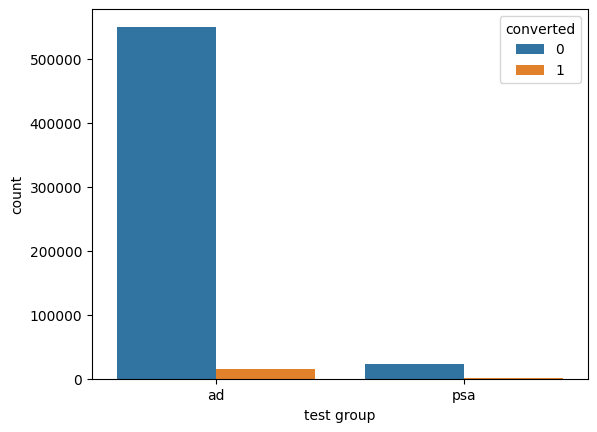

In [13]:
sns.countplot(x='test group', hue='converted', data=marketing)
plt.show()

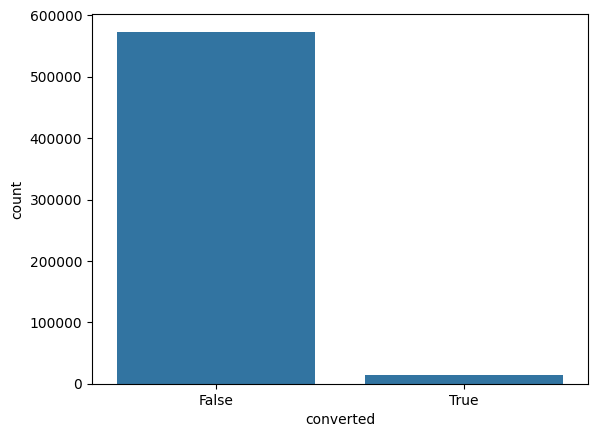

In [73]:
sns.countplot(x='converted', data=marketing)
plt.show()

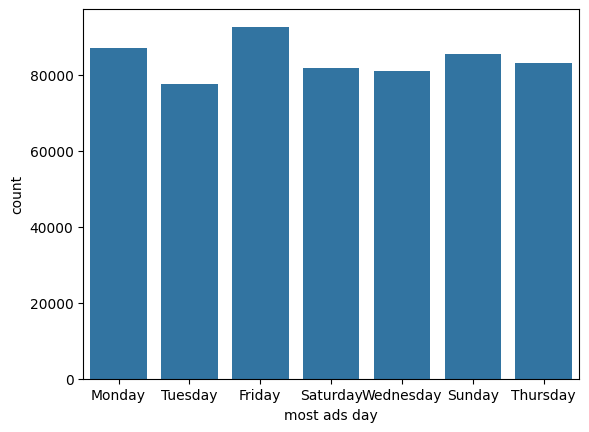

In [15]:
sns.countplot(x='most ads day', data=marketing)
plt.show()

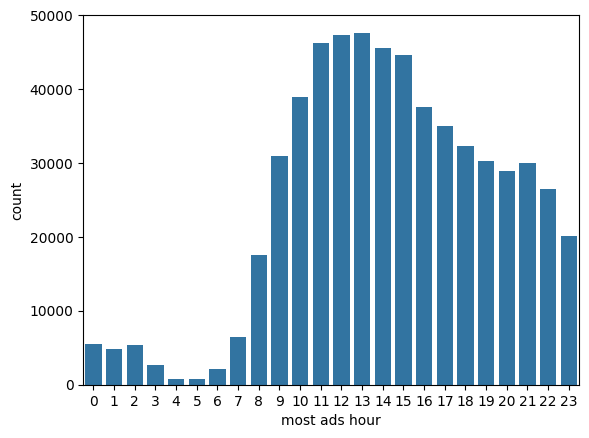

In [16]:
sns.countplot(x='most ads hour', data=marketing)
plt.show()

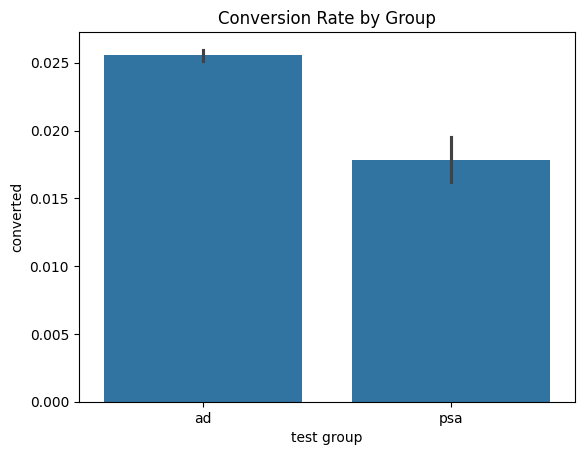

In [17]:
sns.barplot(x='test group', y='converted', data=marketing)
plt.title('Conversion Rate by Group')
plt.show()

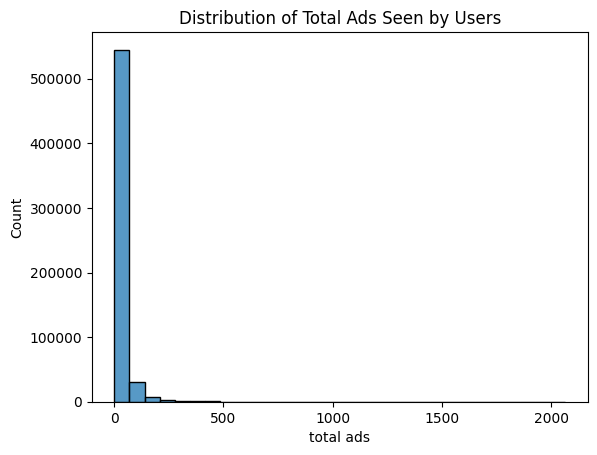

In [18]:
sns.histplot(marketing['total ads'], bins=30)
plt.title('Distribution of Total Ads Seen by Users')
plt.show()

## Step 2: A/B Testing

#### Hypothesis:
- **Null Hypothesis (H0)**: 
There is no difference in conversion rates between users who saw the advertisement and those who saw only the public service announcement.
- **Alternative Hypothesis (H1)**: 
Users exposed to the advertisement have a higher conversion rate than those who only saw the public service announcement.

#### Result:
- Reject the null hypothesis
- Users exposed to the advertisement are significantly more likely to convert than those who only saw the public service announcement.

In [ ]:
from scipy.stats import chi2_contingency

In [71]:
# contingency table
contingency_table = pd.crosstab(marketing['test group'], marketing['converted'])
# marketing.groupby('test group')['converted'].value_counts().unstack()
contingency_table

converted,False,True
test group,,
ad,550154,14423
psa,23104,420


In [72]:
# Chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'chi2: {chi2}\n\np_value: {p_value}\n\ndof: {dof}\n\nexpected:\n {expected}')

chi2: 54.005823883685245

p_value: 1.9989623063390075e-13

dof: 1

expected:
 [[550327.71899045  14249.28100955]
 [ 22930.28100955    593.71899045]]


## Step 3: Model & Prediction (Random forests)

1. build a best random forest model for the marketin dataset
2. predict the conversion of the new data

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import warnings

In [22]:
# data processing
marketing['test group'] = marketing['test group'].replace(['ad', 'psa'], [1, 0])
marketing['converted'] = marketing['converted'].astype(int)
marketing['most ads day'] = marketing['most ads day'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], [1, 2, 3, 4, 5, 6, 7])

In [23]:
# features and target
X = marketing.drop(['user id', 'converted'], axis=1)
y = marketing['converted']

In [52]:
# find the best model (random forest)
warnings.filterwarnings('ignore')

def RandomForestTest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    smote = SMOTE(random_state=218)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    DV = DictVectorizer(sparse=False)
    X_train_encoded = DV.fit_transform(X_train_smote.to_dict(orient='records'))
    X_test_encoded = DV.transform(X_test.to_dict(orient='records'))
    
    RF = RandomForestClassifier(verbose=0)
    
    RF_param = {'n_estimators': [10, 100], 'max_depth': [2, 3, 4, 5]}
    
    GSCV = GridSearchCV(RF, param_grid=RF_param, cv=5)
    GSCV.fit(X_train_encoded, y_train_smote)
    
    print('Accuracy score:', GSCV.score(X_test_encoded, y_test))
    print('The best model param:', GSCV.best_params_)


In [53]:
# the best model result:
RandomForestTest(X, y)

Accuracy score: 0.7948934202113912
The best model param: {'max_depth': 5, 'n_estimators': 100}


In [59]:
# build the best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=218)

smote = SMOTE(random_state=218)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

DV = DictVectorizer(sparse=False)
X_train_encoded = DV.fit_transform(X_train_smote.to_dict(orient='records'))
X_test_encoded = DV.transform(X_test.to_dict(orient='records'))

best_model = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=218)

best_model.fit(X_train_encoded, y_train_smote)

y_pred_train = best_model.predict(X_train_encoded)
y_pred_test = best_model.predict(X_test_encoded)

from sklearn.metrics import accuracy_score, classification_report
print('Training Accuracy:', accuracy_score(y_train_smote, y_pred_train))
print('Test Accuracy:', accuracy_score(y_test, y_pred_test))
print('Classification Report (Test):')
print(classification_report(y_test, y_pred_test))

Training Accuracy: 0.79427391065663
Test Accuracy: 0.8129446492457116
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    143366
           1       0.09      0.76      0.17      3660

    accuracy                           0.81    147026
   macro avg       0.54      0.79      0.53    147026
weighted avg       0.97      0.81      0.88    147026



In [66]:
# predic new data
user1_data = {
    'test group': [1],
    'total ads': [40],
    'most ads day': [5],
    'most ads hour': [17]
}

user1_df = pd.DataFrame(user1_data)

user1_transformed = DV.transform(user1_df.to_dict(orient='records'))

predicted_1 = best_model.predict(user1_transformed)

if predicted_1[0] == 1:
    print('Prediction: user1 will buy the product.')
else:
    print('Prediction: user1 will not buy the product。')

Prediction: user1 will buy the product.
